In [1]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
# from utilities3 import LpLoss
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import math
from sklearn.model_selection import train_test_split
from functools import reduce
from functools import partial
import operator
from timeit import default_timer
from matplotlib.ticker import FormatStrFormatter
import deepxde as dde
from scipy import linalg
from scipy.interpolate import interp1d

Using backend: pytorch



In [2]:
def solveBetaFunction(x, gamma, amp):
    beta = np.zeros(len(x))
    for idx, val in enumerate(x):
        beta[idx] = amp*math.cos(gamma*math.acos(val))
    return beta

def buildF(x, gamma1, amp1, gamma2, amp2):
    b1 = solveBetaFunction(x, gamma1, amp1)
    b2 = solveBetaFunction(x, gamma2, amp2)
    nx = len(x)
    f = np.zeros((nx, nx))
    for idx, val in enumerate(x):
        for idx2, val2 in enumerate(x):
            if idx <= idx2:
                f[idx][idx2] = b1[idx]*b2[idx2]
    return f

def buildtau(nx,tau):
    tau_matrix = tau * np.ones((nx, nx))
    # tau_matrix = np.triu(tau_matrix)
    tau_matrix = tau_matrix.reshape(1, -1)
    return tau_matrix

def buildCof_int_x_1(x, dx):
    nx = len(x)
    cof_int_x_1 = np.triu(np.ones((nx,nx)))
    cof_int_x_1[:,-1]=1/2*np.ones((1,nx))
    cof_int_x_1= dx*(cof_int_x_1-1/2*np.eye(nx))
    return cof_int_x_1

def buildCof_int_0_x(x, dx):
    nx = len(x)
    cof_int_0_x = np.tril(np.ones((nx,nx)))
    cof_int_0_x[:,0]=1/2*np.ones((1,nx))
    cof_int_0_x= dx*(cof_int_0_x-1/2*np.eye(nx))
    return cof_int_0_x

def findinterpolation(kappabud, spatial1, spatial2):
    fx = interp1d(spatial1, kappabud, kind="cubic")
    kappabudInterp = fx(spatial2)
    return kappabudInterp

def zeroToNan(x):
    for j in range(len(x)):
        for i in range(len(x)):
            if i > j:
                x[i][j] = float('nan')
    return x

def LowTriTozero(x):
    for j in range(len(x)):
        for i in range(len(x)):
            if i > j:
                x[i][j] = float(0)
    return x

def solveControl(u, Kbud, Lbud, Jbud, nx, dx, tau_obs, k):
    return (sum(Kbud*u[0:nx]*dx) +tau_obs*sum(Lbud*u[nx:2*nx]*dx)+k*sum(Jbud*u[2*nx:3*nx]*dx)
            - Kbud[0]*u[0]*dx/2
            - Kbud[nx-1]*u[nx-1]*dx/2
            - tau_obs*Lbud[0]*u[nx]*dx/2
            - tau_obs*Lbud[nx-1]*u[2*nx-1]*dx/2
            - k*Jbud[0]*u[2*nx]*dx/2
            - k*Jbud[nx-1]*u[3*nx-1]*dx/2)

def solveOpenLoop(_, _a, _b, _c, _d, _e, _f, _g):
    return 0

def fastKernelCalc(f, c, tau, tau_obs, x, cof_int_x_1, cof_int_0_x):
    nx = len(x) 
    dx=x[2]-x[1]
    k=tau-tau_obs
    Ntau=int(tau/dx)+1
    K = np.zeros((nx, nx))
    result = 0
    for i in range(nx-2, -1, -1):
        result += (f[[i+1],[i+1]] + f[[i],[i]])*dx/2*(-1)
        K[i,i] = result
    for i in range(nx-2, -1, -1):
        num = nx - i
        A1 = np.diag([-2]*num) + np.diag([1]*(num-1),1)
        A1[[0],[0]] = 1
        A1[[0],[1]] = 0
        A1[[-1],[-1]] = 1

        A121=np.zeros((num,num))
        A122=np.zeros((num,num))
        A121[1:num-1,0:num-1]= f.T[i+1:i-1+num,i:i-1+num]
        A122[0:num-1,0:num-1] = dx*cof_int_0_x[0:num-1,0:num-1] 
        A1 = A1+ A121*A122
        B1=np.zeros((num,1))
        B1[[0],[0]] = K[[i],[i]]
        B1[1:num-1,0] =-K[[i+1],i+1:nx-1].reshape((num-2)) +(dx*f[i,i+1:nx-1]).reshape((num-2))
        if i+ Ntau<nx:
            B1[num-1,0]=sum(cof_int_x_1[i+Ntau-1,:]*K[i+Ntau-1,:]*c)-c[i+Ntau-1]
        else:
            B1[num-1,0]=0
        D=np.linalg.solve(A1,B1)
        K[[i],i:nx]=D.T

    J=np.zeros((nx, nx))
    c_matrix=np.repeat(c[np.newaxis,:], nx, 0)
    J[0:nx,0]=np.sum(cof_int_x_1*c_matrix*K, axis=1)-c[0:nx]
    AJ = np.diag([k+1]*nx) + np.diag([-1]*(nx-1),-1)
    AJ[0,0]=1
    for i in range(nx-2, -1, -1):
        BJ=np.zeros((nx,1))
        BJ[0,0]=J[i,0]
        BJ[1:nx,0]=k*J[i+1,1:nx]
        J[[i],0:nx]=(np.linalg.solve(AJ,BJ)).T
    
    L=np.zeros((nx, nx))
    L[0:nx,0]=J[0:nx,-1]
    AL = np.diag([tau_obs+1]*nx) + np.diag([-1]*(nx-1),-1)
    AL[0,0]=1
    for i in range(nx-2, -1, -1):
        BL=np.zeros((nx,1))
        BL[0,0]=L[i,0]
        BL[1:nx,0]=tau_obs*L[i+1,1:nx]
        L[[i],0:nx]=(np.linalg.solve(AL,BL)).T
    return K, L, J

def solvePDE(tau, tau_obs, c, f, Kbud, Lbud, Jbud, init_condition, x, t, printFreq=500):
    k=tau-tau_obs
    nx = len(x)
    nt = len(t)
    dx=x[1]-x[0]
    dt=t[1]-t[0]
    uu = np.zeros((nt, 3*nx))
    uu[0,:] = init_condition
    for i in range(1, nt):
        if i%int(1000) == 0:
            print("Completed:", i, "/", nt, flush=True)
            
        uu[i][0] = solveControl(uu[i-1], Kbud, Lbud, Jbud, nx, dx,tau_obs,k)
        fres = np.zeros(nx)
        for j in range(1, nx):
            fres[j] = sum(f[j][j:nx]*uu[i-1][j:nx])*dx-f[j][j]*uu[i-1][j]*dx/2-f[j][nx-1]*uu[i-1][nx-1]*dx/2
        uu[i][2*nx-1]=uu[i-1][nx-1]
        uu[i][nx:2*nx-1] = uu[i-1][nx:2*nx-1]+dt/(tau_obs*dx)*(uu[i-1][nx+1:2*nx]-uu[i-1][nx:2*nx-1])
        uu[i][3*nx-1]=uu[i-1][nx]
        uu[i][2*nx:3*nx-1] = uu[i-1][2*nx:3*nx-1]+dt/(k*dx)*(uu[i-1][2*nx+1:3*nx]-uu[i-1][2*nx:3*nx-1])
        uu[i][1:nx] = uu[i-1][1:nx] - dt/dx*(uu[i-1][1:nx] - uu[i-1][0:nx-1]) + dt*fres[1:nx] + dt*c[1:nx]*uu[i-1][nx]
    return uu

In [3]:
def set_size(width, fraction=1, subplots=(1, 1), height_add=0):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = height_add + fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "times",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/bel fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
}

plt.rcParams.update(tex_fonts)

In [4]:
## time
T = 10
dt = 0.001
nt = int(round(T/dt))+1
temporal = np.linspace(0, T, nt)
## space
X = 1
# dx = dt*a
dx = 0.02
nx = int(round(X/dx))+1
spatial = np.linspace(0, X, nx)

cof_int_x_1 = buildCof_int_x_1(spatial, dx)
cof_int_0_x = buildCof_int_0_x(spatial, dx)

## system parameters
# tau = 1.8
# tau_obs = 0.3
# k=tau-tau_obs

# c=1-spatial
# f =buildF(spatial, 5, 3, 5, 3)

In [9]:
# Parameters tranin for JL
ndata1 = 10 #tau
ndata2 = 10 #tau_obs
ndata3 = 10 #f
ndata4 = 10 #c
ndata=ndata1*ndata2*ndata3*ndata4
epochs =300
ntrain = 9000
ntest = 1000
batch_size = 20
gamma = 0.6
learning_rate = 0.0002
step_size= 50
# modes=12
# width=32

In [ ]:
# # Dataset generation for JL
inpArr = []
outArr = []
tauArr = []
tauobsArr = []
fArr = []
cArr = []
# # tau=1
for i in range(ndata1):
        tauArr.append(np.random.uniform(0.8, 2))
for i in range(ndata2):
        tauobsArr.append(np.random.uniform(0.1, 0.7))
for i in range(ndata3):
        f = buildF(spatial, np.random.uniform(3, 6), 3, np.random.uniform(3, 6), 3)
        fArr.append(f)
for i in range(ndata4):
        c = solveBetaFunction(spatial, np.random.uniform(3, 6), 1)
        c = c-c[-1]
        cArr.append(c) 
jj=0
for tau in tauArr:
        for tau_obs in tauobsArr:
                for f in fArr:
                        for c in cArr:
                                jj+=1
                                if jj % 1000 == 0:
                                        print("Completed", jj, "/", ndata)
                                K,L,J=fastKernelCalc(f, c, tau, tau_obs, spatial, cof_int_x_1, cof_int_0_x)
                                tau_matrix=buildtau(nx,tau)
                                tauobs_matrix=buildtau(nx,tau_obs)
                                c_matrix=buildtau(nx,c)
                                tempin=np.concatenate([tauobs_matrix,tau_matrix,f.reshape(1,-1),c_matrix.reshape(1,-1)],axis=1)
                                tempout = np.concatenate([K.reshape(1,-1), L.reshape(1,-1), J.reshape(1,-1)],axis=1)
                                inpArr.append(tempin)
                                outArr.append(tempout)

##########
x = np.array(inpArr) 
y = np.array(outArr)

In [ ]:
# x = x.reshape(x.shape[0],4*nx*nx)
# y = y.reshape(y.shape[0],3*nx*nx)
# np.savetxt("xlj.dat", x)
# np.savetxt("ylj.dat", y)

In [10]:
inpArr = np.loadtxt("x50_0717k1k2k3.dat", dtype=np.float32)
outArr = np.loadtxt("y50_0717k1k2k3.dat", dtype=np.float32)
x = np.array(inpArr)
y = np.array(outArr)

In [7]:
grids0 = []
grids0.append(np.linspace(0, 1, nx, dtype=np.float32))
grids0.append(np.linspace(0, 1, nx, dtype=np.float32))
grid0 = np.vstack([xx.ravel() for xx in np.meshgrid(*grids0)]).T
grid = torch.from_numpy(grid0).cuda()

In [11]:
# Create train/test splits
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=1)
x_train = torch.from_numpy(x_train).cuda()
y_train = torch.from_numpy(y_train).cuda()
x_test = torch.from_numpy(x_test).cuda()
y_test = torch.from_numpy(y_test).cuda()

trainData = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True, generator=torch.Generator(device='cuda'))
testData = DataLoader(TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False, generator=torch.Generator(device='cuda'))

In [12]:
def count_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

In [ ]:
class BranchNet1(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=64,
                       kernel_size=5, stride=2)
        self.relu = torch.nn.ReLU()
        self.conv2 = torch.nn.Conv2d(in_channels=64, out_channels=128,
                       kernel_size=5, stride=2)
        self.relu = torch.nn.ReLU()
        self.fc1 = torch.nn.Linear(12800, 512)
        self.fc2 = torch.nn.Linear(512, 256)
        
    def forward(self, x):
        x = torch.reshape(x, (x.shape[0], 3, self.shape, self.shape))
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [13]:
class BranchNet2(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape
        self.conv1 = torch.nn.Conv2d(in_channels=4, out_channels=64,
                       kernel_size=5, stride=2)
        self.relu = torch.nn.ReLU()
        self.conv2 = torch.nn.Conv2d(in_channels=64, out_channels=128,
                       kernel_size=5, stride=2)
        self.relu = torch.nn.ReLU()
        self.fc1 = torch.nn.Linear(12800, 512)
        self.fc2 = torch.nn.Linear(512, 256)
        
    def forward(self, x):
        x = torch.reshape(x, (x.shape[0], 4, self.shape, self.shape))
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [14]:
# Define a sequential torch network for batch and trunk. Can use COV2D which we will show later
dim_x = 2
# m = int(nx*(nx+1)/2)
# m1 = 3*nx*nx
m = 4*nx*nx
# branchk1 = BranchNet1(nx)
branchk2 = BranchNet2(nx)
branchk3 = BranchNet2(nx)
# modelk1 = dde.nn.DeepONetCartesianProd([m1, branchk1], [dim_x, 128,  256], "relu", "Glorot normal").cuda()
modelk2 = dde.nn.DeepONetCartesianProd([m, branchk2], [dim_x, 128,  256], "relu", "Glorot normal").cuda()
modelk3 = dde.nn.DeepONetCartesianProd([m, branchk3], [dim_x, 128,  256], "relu", "Glorot normal").cuda()
# print(count_params(modelk1))
print(count_params(modelk2))
print(count_params(modelk3))

6930241
6930241


In [15]:
optimizer = torch.optim.Adam([  
	{'params': modelk2.parameters(), 'lr': learning_rate,},
    {'params': modelk3.parameters(), 'lr': learning_rate,}
	])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

In [16]:
# loss = nn.MSELoss()
loss = torch.nn.SmoothL1Loss(reduction='mean', beta=1.0)

train_lossArr = []
test_lossArr = []
time_Arr = []

for ep in range(epochs):
    # modelk1.train()
    modelk2.train()
    modelk3.train()
    t1 = default_timer()
    train_loss = 0
    for x, y in trainData:
        x, y = x.cuda(), y.cuda()
        # x1=x[:,nx*nx:4*nx*nx]
        # y1=y[:,0:nx*nx]
        y2=y[:,nx*nx:2*nx*nx]
        y3=y[:,2*nx*nx:3*nx*nx]
        optimizer.zero_grad()
        # out1 = modelk1((x1, grid))
        out2 = modelk2((x, grid))
        out3 = modelk3((x, grid))
        lp =  loss(out2.view(batch_size, -1), y2.view(batch_size, -1)) \
        + loss(out3.view(batch_size, -1), y3.view(batch_size, -1))
        lp.backward()
        
        optimizer.step()
        train_loss += lp.item()
        
    scheduler.step()
    # modelk1.eval()
    modelk2.eval()
    modelk3.eval()
    test_loss = 0
    with torch.no_grad():
        for x, y in testData:
            x, y = x.cuda(), y.cuda()
            # x1=x[:,nx*nx:4*nx*nx]
            # y1=y[:,0:nx*nx]
            y2=y[:,nx*nx:2*nx*nx]
            y3=y[:,2*nx*nx:3*nx*nx]
            # out1 = modelk1((x1, grid))
            out2 = modelk2((x, grid))
            out3 = modelk3((x, grid))
            test_loss +=  loss(out2.view(batch_size, -1), y2.view(batch_size, -1)).item() \
            +loss(out3.view(batch_size, -1), y3.view(batch_size, -1)).item()
            
    train_loss /= len(trainData)
    test_loss /= len(testData)
    
    train_lossArr.append(train_loss)
    test_lossArr.append(test_loss)
    
    t2 = default_timer()
    time_Arr.append(t2-t1)
    if ep%50 == 0:
        print(ep, t2-t1, np.mean(train_lossArr[-50:]), np.mean(test_lossArr[-50:]))

0 5.594270129979122 0.14300458719746934 0.04059408810571767
50 4.5899307249928825 0.0025801996136122995 0.0022815816026191898
100 4.559587825031485 0.00020840784454679426 0.0002262040602272009
150 4.499761865998153 7.660821501016875e-05 8.135461645802024e-05
200 4.430867650022265 4.072323089745218e-05 4.109157968471208e-05
250 4.472816474037245 2.5823859095827276e-05 2.7709249410145272e-05


Text(0.5, 0, '$\\mathrm{epoch}$')

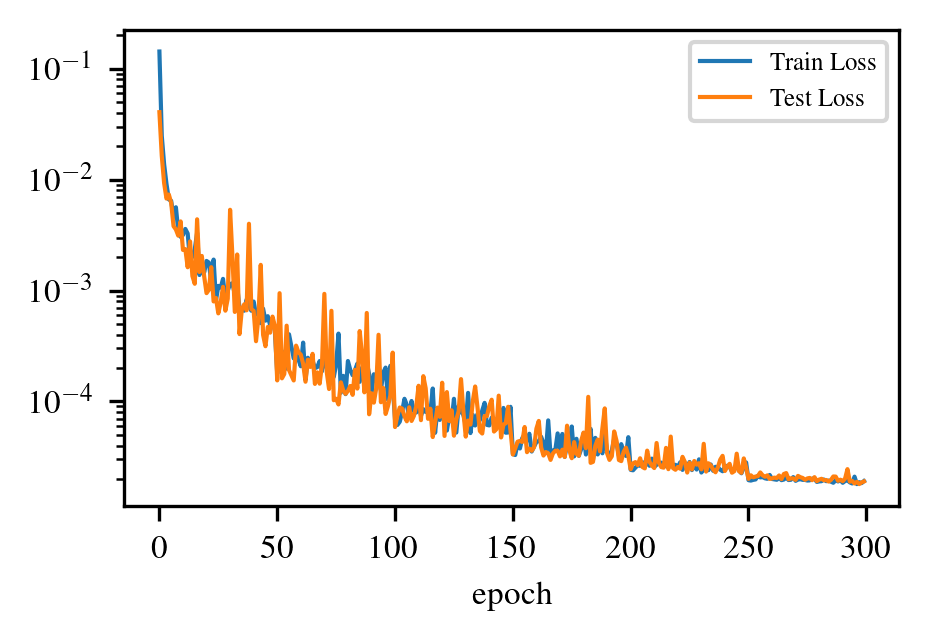

In [17]:
plt.figure(figsize=(1000 / 300, 618 / 300), dpi=300)
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.plot(train_lossArr, label="Train Loss",linewidth=1)
plt.plot(test_lossArr, label="Test Loss",linewidth=1)


plt.yscale("log")
plt.legend(fontsize="6")
plt.tick_params(labelsize=8)
plt.xlabel(r"$\mathrm{epoch}$",fontsize = 8 )
# plt.savefig('img/LJloos.eps', dpi=300,bbox_inches='tight')

In [18]:
tau = 1
tau_obs = 0.5
k=tau-tau_obs 
c=solveBetaFunction(spatial, 5, 1)
c = c-c[-1]
f =buildF(spatial, 5, 3, 5, 3)

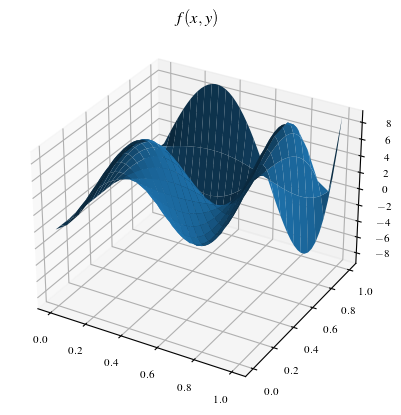

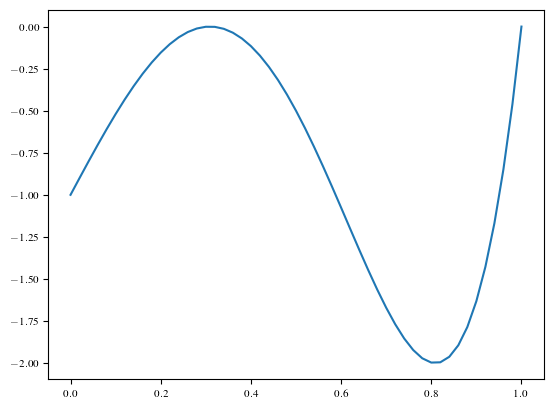

In [19]:
meshy, meshx = np.meshgrid(spatial, spatial)
fig = plt.figure()
ax = plt.axes(projection='3d')
surf = ax.plot_surface(meshx, meshy, zeroToNan(f))
ax.set_title(r"$f(x,y)$")

fig_intep=plt.figure()
plt.plot(spatial, c)

In [20]:
f =buildF(spatial, 5, 3, 5, 3)
K, L, J=fastKernelCalc(f, c, tau, tau_obs, spatial, cof_int_x_1, cof_int_0_x)

In [21]:
f =buildF(spatial, 5, 3, 5, 3)
tau_matrix=buildtau(nx,tau)
tauobs_matrix=buildtau(nx,tau_obs)
c_matrix=buildtau(nx,c)
xdata=np.concatenate([tauobs_matrix,tau_matrix,f.reshape(1,-1),c_matrix.reshape(1,-1)],axis=1)
 
xdata = np.array(xdata, dtype=np.float32)
xdata = torch.from_numpy(xdata.reshape((1, 4*nx*nx))).cuda()

In [ ]:
xdata1=xdata[:,nx*nx:4*nx*nx]

In [ ]:
# k1= modelk1((xdata1, grid))
# k1 = k1.detach().cpu().numpy().reshape(1, nx*nx)
# k1=k1.reshape(nx,nx)

In [22]:
k2= modelk2((xdata, grid))
k2 = k2.detach().cpu().numpy().reshape(1, nx*nx)
k3= modelk3((xdata, grid))
k3 = k3.detach().cpu().numpy().reshape(1, nx*nx)
k2=k2.reshape(nx,nx)
k3=k3.reshape(nx,nx)

Text(0.5, 0.92, '$L(x,y)-\\hat L(x,y)$')

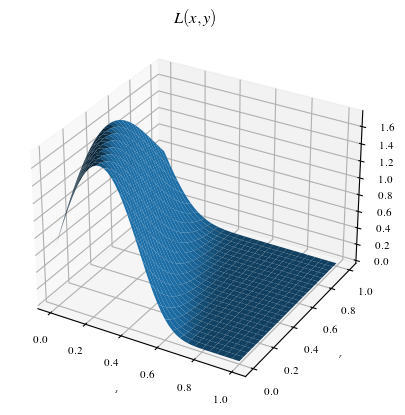

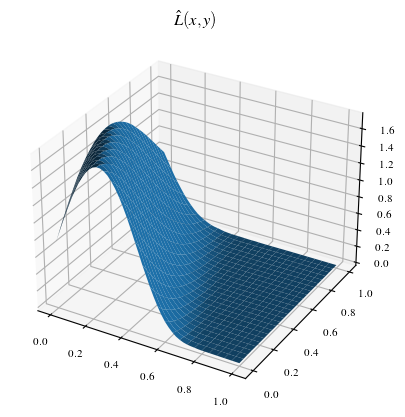

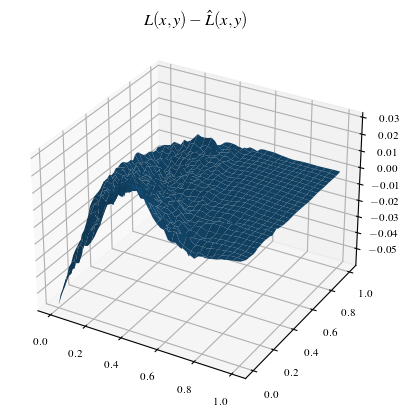

In [23]:
###
fig5 = plt.figure()
ax = plt.axes(projection='3d')
surf = ax.plot_surface(meshx, meshy, L)
ax.set_title(r"$L(x,y)$") 
ax.set_xlabel(r"$s$",fontsize = 5 )
ax.set_ylabel(r"$r$",fontsize = 5 )
ax.set_zlabel(r"$L(s,r)$", fontsize = 5 )



fig6 = plt.figure()
ax = plt.axes(projection='3d')
surf = ax.plot_surface(meshx, meshy, k2)
ax.set_title(r"$\hat L(x,y)$") 
# ax.set_zticks([-2, 0, 2])
fig7 = plt.figure()
ax = plt.axes(projection='3d')
surf = ax.plot_surface(meshx, meshy, L-k2)
ax.set_title(r"$L(x,y)-\hat L(x,y)$")
# ax.set_zticks([-2, 0, 2])

Text(0.5, 0.92, '$J-\\hat{J}$')

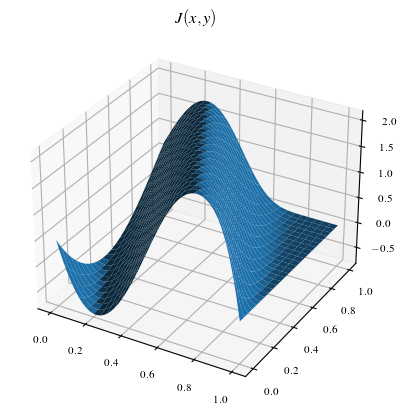

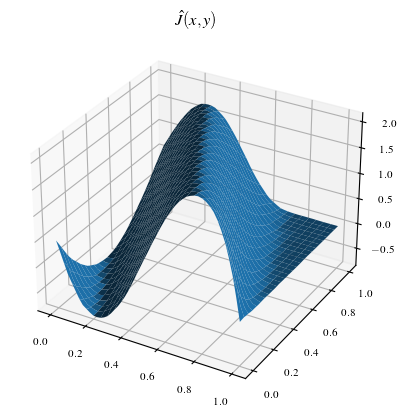

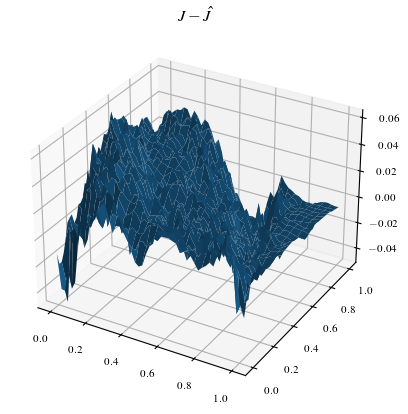

In [24]:
###
fig5 = plt.figure()
ax = plt.axes(projection='3d')
surf = ax.plot_surface(meshx, meshy, J)
ax.set_title(r"$J(x,y)$")
fig6 = plt.figure()
ax = plt.axes(projection='3d')
surf = ax.plot_surface(meshx, meshy, k3)
ax.set_title(r"$\hat{J}(x,y)$")
fig7 = plt.figure()
ax = plt.axes(projection='3d')
surf = ax.plot_surface(meshx, meshy, J-k3)
ax.set_title(r"$J-\hat{J}$")

In [ ]:
path2='./Model/cftauToCtrlTorchMode2.pth'
path3='./Model/cftauToCtrlTorchMode3.pth'
torch.save(modelk2.state_dict(), path2)
torch.save(modelk3.state_dict(), path3)

In [ ]:
# path1='./Model/cftauToCtrlTorchMode1.pth' 
# path2='./Model/cftauToCtrlTorchMode2.pth'
# path3='./Model/cftauToCtrlTorchMode3.pth'
# modelk1.load_state_dict(torch.load(path1))
# modelk2.load_state_dict(torch.load(path2))
# modelk3.load_state_dict(torch.load(path3))

In [25]:
shr=meshx+tau_obs*meshy
skr=meshx+(tau-tau_obs)*meshy

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


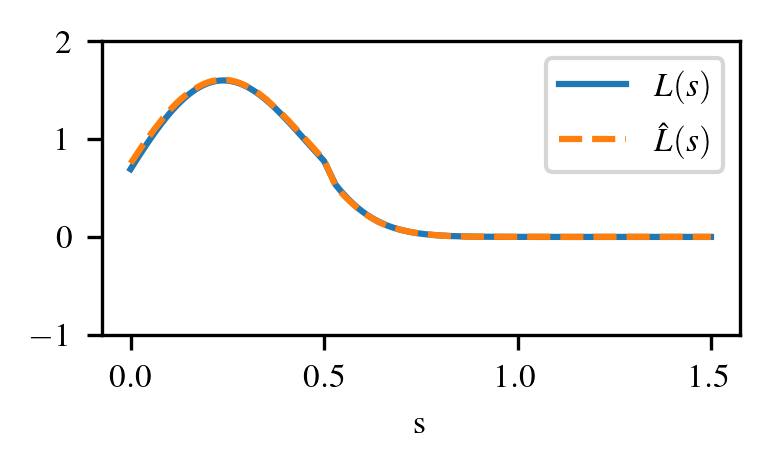

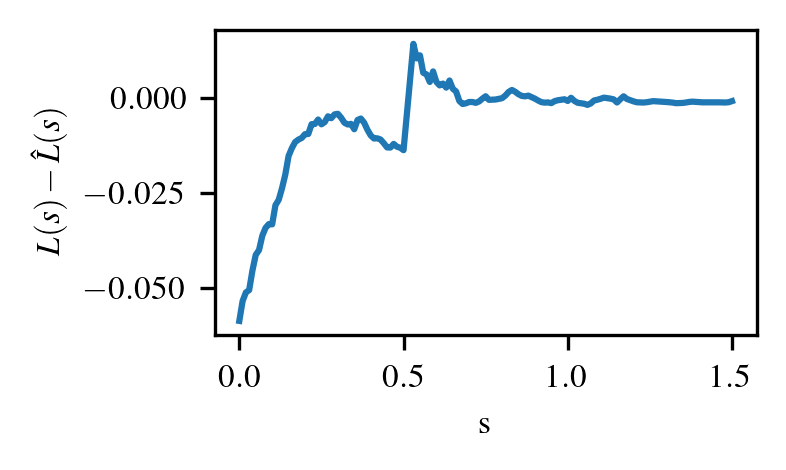

In [26]:
my_dpi=300
LLL_x=np.concatenate([skr[0,:],skr[25,3:51],skr[50,1:51]])
LLL_y=np.concatenate([L[0,:],L[25,3:51],L[50,1:51]])
LLL_learning_y=np.concatenate([k2[0,:],k2[25,3:51],k2[50,1:51]])
fig_intep=plt.figure(figsize=(800 / my_dpi, 500 / my_dpi), dpi=my_dpi)
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.plot(LLL_x, LLL_y,linewidth=1.5,label=r'$L(s)$') 
plt.plot(LLL_x, LLL_learning_y,linewidth=1.5,linestyle='--',label=r'$\hat L(s)$') 
plt.legend(loc="upper right",fontsize="8")
# plt.legend(loc="best",fontsize="8")
plt.xlabel(r'$\rm{s}$',fontsize="8")
# plt.ylabel(r'$J(s,t) $',fontsize="8")
plt.yticks(np.arange(-1,2.5,1))
plt.tick_params(labelsize=8)




fig = plt.gcf()
fig.tight_layout()
# plt.savefig('img/L_sigma.eps', dpi=300,bbox_inches='tight')

fig_intep=plt.figure(figsize=(800 / my_dpi, 500 / my_dpi), dpi=my_dpi)
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.plot(LLL_x, LLL_y- LLL_learning_y,linewidth=1.5,label=r'$L(s)-\hat L(s)$')  
# plt.legend(loc="upper right",fontsize="8")
# plt.legend(loc="best",fontsize="8")
plt.xlabel(r'$\rm{s}$',fontsize="8")
plt.ylabel(r'$L(s)-\hat L(s) $',fontsize="8")
# plt.yticks(np.arange(-0.5,1,0.3))
plt.tick_params(labelsize=8)

fig = plt.gcf()
fig.tight_layout()
# plt.savefig('img/L_error_sigma.eps', dpi=300,bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


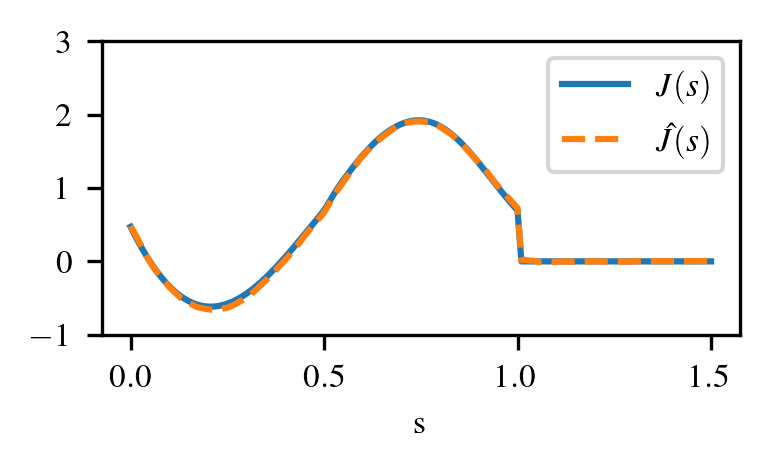

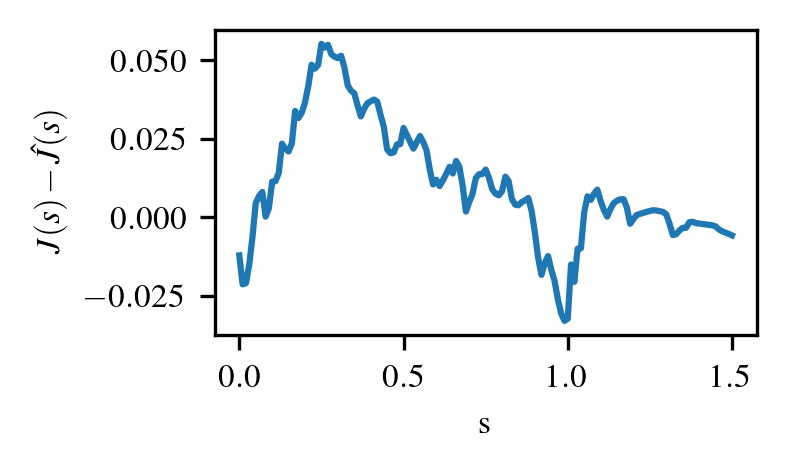

In [27]:
my_dpi=300
JJJ_x=np.concatenate([skr[0,:],skr[25,3:51],skr[50,1:51]])
JJJ_y=np.concatenate([J[0,:],J[25,3:51],J[50,1:51]])
JJJ_learning_y=np.concatenate([k3[0,:],k3[25,3:51],k3[50,1:51]])
fig_intep=plt.figure(figsize=(800 / my_dpi, 500 / my_dpi), dpi=my_dpi)
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.plot(JJJ_x, JJJ_y,linewidth=1.5,label=r'$J(s)$') 
plt.plot(JJJ_x, JJJ_learning_y,linewidth=1.5,linestyle='--',label=r'$\hat J(s)$') 
plt.legend(loc="upper right",fontsize="8")
# plt.legend(loc="best",fontsize="8")
plt.xlabel(r'$\rm{s}$',fontsize="8")
# plt.ylabel(r'$J(s,t) $',fontsize="8")
plt.yticks(np.arange(-1,4,1))
plt.tick_params(labelsize=8)




fig = plt.gcf()
fig.tight_layout()
# plt.savefig('img/J_sigma.eps', dpi=300,bbox_inches='tight')

fig_intep=plt.figure(figsize=(800 / my_dpi, 500 / my_dpi), dpi=my_dpi)
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.plot(JJJ_x, JJJ_y- JJJ_learning_y,linewidth=1.5,label=r'$J(s)-\hat J(s)$')  
# plt.legend(loc="upper right",fontsize="8")
# plt.legend(loc="best",fontsize="8")
plt.xlabel(r'$\rm{s}$',fontsize="8")
plt.ylabel(r'$J(s)-\hat J(s) $',fontsize="8")
# plt.yticks(np.arange(-1,1.5,0.5))
plt.tick_params(labelsize=8)

fig = plt.gcf()
fig.tight_layout()
# plt.savefig('img/J_error_sigma.eps', dpi=300,bbox_inches='tight')